In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os.path
import os
from os.path import join
from threading import Thread
import time
import gc

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from keras.layers import Conv2D, Input, Activation
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Dropout
from keras.layers.merge import Add
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D, Conv2DTranspose, ZeroPadding2D, Cropping2D
from keras.losses import binary_crossentropy
from keras.models import load_model
from keras.models import Sequential, Model
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import keras.backend as K

from scipy import misc

Using TensorFlow backend.


In [2]:
### Settings ###
input_folder = '../input'
# Location of train images
x_input = join(input_folder, 'test')
# Save predictions
save_predictions = 'predictions'
# Image dimensions
img_w = 1918 #1918
img_h = 1280 #1280
# Define view of car used for training
angles = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16']
models = ['model_v4.4-test-new-gpu_01_weights.0.9968.hdf5', 
        'model_v4.4-test-new-gpu_02_weights.0.9970.hdf5',
        'model_v4.4-test-new-gpu_03_weights.0.9974.hdf5',
        'model_v4.4-test-new-gpu_04_weights.0.9970.hdf5',
        'model_v4.4-test-new-gpu_05_weights.0.9970.hdf5',
        'model_v4.4-test-new-gpu_06_weights.0.9973.hdf5',
        'model_v4.4-test-new-gpu_07_weights.0.9977.hdf5',
        'model_v4.4-test-new-gpu_08_weights.0.9978.hdf5',
        'model_v4.4-test-new-gpu_09_weights.0.9975.hdf5',
        'model_v4.4-test-new-gpu_10_weights.0.9976.hdf5',
        'model_v4.4-test-new-gpu_11_weights.0.9981.hdf5',
        'model_v4.4-test-new-gpu_12_weights.0.9976.hdf5',
        'model_v4.4-test-new-gpu_13_weights.0.9975.hdf5',
        'model_v4.4-test-new-gpu_14_weights.0.9976.hdf5',
        'model_v4.4-test-new-gpu_15_weights.0.9982.hdf5',
        'model_v4.4-test-new-gpu_16_weights.0.9978.hdf5'
         ]
# Variable for dice_coef
smooth = 1
# Data generator parameters
data_gen_args_train = dict(zca_epsilon=0,
                          featurewise_center=True,
                          featurewise_std_normalization=True)
datagen_test = ImageDataGenerator(**data_gen_args_train)

datagen_test.std = np.array([[[ 58.49208069,  58.91231155,  58.01151657]]], dtype=np.float32)
datagen_test.mean = np.array([[[ 111.84810638,  111.84810638,  111.84810638]]], dtype=np.float32)
datagen_test.augment = True

In [3]:
# From here: https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/master/train.py
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def bce_dice_loss(y_true, y_pred):
    return 0.5 * binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

def ret_angle_list(x_list, angle):
    angle = '_' + angle
    k = [x.find(angle) for x in x_list['img']]
    k = np.array(k)
    
    k[k>0] = 1
    k[k<0] = 0
    
    k = [i if x==1 else None for i,x in enumerate(k)]
    k = [value for value in k if value != None]
    k = pd.DataFrame([x_list['img'][i] for i in k], columns=['img'])
    return k

def remove_obj_rti(obj):
    gc.collect()
    del obj.obj
    del obj.queue
    del obj
    gc.collect()

In [4]:
# Add full location of test data for all images
test_data_files = os.listdir(x_input)
for i, file in enumerate(test_data_files):
    test_data_files[i] = join(x_input, file)
# Make it into Data Frame so you can feed it into function ret_angle_list
pd_test_data = pd.DataFrame(test_data_files, columns=['img'])

In [5]:
# Fill array with images
class getTestData:
    
    def __init__(self, datagen):
        self.datagen = datagen
    
    def run(self, arr_x, arr_names, img_files, per_array=30):
        
        self.arr_x = arr_x
        self.arr_names = arr_names
        self.img_files = img_files
        self.per_array = per_array
        
        self.thread = Thread(target = self.fill_array)
        self.thread.start()
    
    def fill_array(self):

        while(True):
            if(len(self.arr_x) <3):
                threads = []
                img_to_arr = self.img_files[0:self.per_array]
                del self.img_files[0:self.per_array]
                
                x = [None] * self.per_array

                for i, file in enumerate(img_to_arr):
                    thread = Thread(target=self.read_img, args=(file, x, i))
                    thread.start()
                    threads.append(thread)

                for t in threads:
                    t.join()
                
                for x_augmented in self.datagen.flow(np.array(x), batch_size=self.per_array, shuffle=False):
                    x = x_augmented
                    break
                
                self.arr_x.append(x)
                names = [f.split('/')[-1] for f in img_to_arr]
                self.arr_names.append(names)

                # At the end
                if(self.per_array > len(self.img_files)):
                    self.per_array = len(self.img_files)
                if(len(self.img_files) == 0):
                    break

                gc.collect()

            else:
                time.sleep(1)

    def read_img(seslf, file, x, loc):
        x[loc] = misc.imread(file)

In [6]:
def save_pred_to_file(y, path, name):
    misc.imsave(join(path, name), y)

In [7]:
while len(models) > 0:
    m = models.pop(0)
    a = angles.pop(0)
    array_x = []
    array_names = []
    angleXX = ret_angle_list(pd_test_data, a)['img'].tolist()
    obj = getTestData(datagen_test)
    obj.run(array_x, array_names, angleXX)
    model = load_model(m, 
                   custom_objects={'bce_dice_loss': bce_dice_loss, 
                                   'dice_coef': dice_coef})
    flag = False
    
    while True:
        # Break when array_x and angleXX is empty. Just to be sure sleep 5 seconds before
        if (len(array_x) == 0 and len(angleXX) == 0):
            if(flag):
                break
            flag = True
            time.sleep(5)
            print ('sleeping 5')
            
        if(len(array_x) != 0):
            # Get data and make predictions
            start_time = time.time()
            x = np.array(array_x.pop(0))
            f = array_names.pop(0)
            y = model.predict(x, 1)
            # Write images to disk using threading
            threads = []
            for i, y_ in enumerate(y):
                    thread = Thread(target=save_pred_to_file, args=(np.squeeze(y_,2), save_predictions, f[i]))
                    threads.append(thread)
                    
            for thread in threads:
                thread.start()
                
        else:
            time.sleep(1)
            print ('sleeping 1')
    
    # Delete unneeded objects
    del obj.arr_x
    del obj.arr_names
    del obj.img_files
    del obj.thread
    del obj
    del array_x
    gc.collect()

sleeping 5
sleeping 1
sleeping 5
sleeping 1
sleeping 5
sleeping 1
sleeping 5
sleeping 1
sleeping 5
sleeping 1
sleeping 5
sleeping 1
sleeping 5
sleeping 1
sleeping 5
sleeping 1
sleeping 5
sleeping 1
sleeping 5
sleeping 1
sleeping 5
sleeping 1
sleeping 5
sleeping 1
sleeping 5
sleeping 1
sleeping 5
sleeping 1
sleeping 5
sleeping 1
sleeping 5
sleeping 1


In [8]:
m = models.pop(0)
a = angles.pop(0)
x = array_x.pop(0)

In [10]:
np.shape(array_x[2])

(2, 1280, 1918, 3)

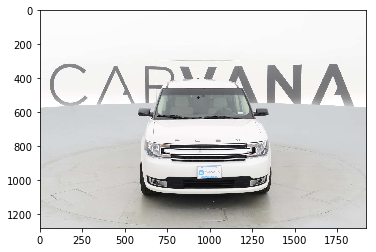

0ab2e2edfa32_01.jpg


In [8]:
plt.imshow(array_x[0][25])
plt.show()
print(array_names[0][25])

In [14]:
x = np.array(array_x.pop(0))

In [8]:
x[0]

array([[254, 250, 247],
       [254, 250, 247],
       [254, 250, 247],
       ..., 
       [255, 251, 248],
       [255, 251, 248],
       [255, 251, 248]], dtype=uint8)

In [10]:
save_predictions

'predictions'

In [11]:
y_, save_predictions, f[i]

'000aa097d423_01.jpg'

In [9]:
misc.imsave(join(save_predictions, f[0]), y_)

ValueError: 'arr' does not have a suitable array shape for any mode.

In [12]:
np.squeeze(y_,2).shape

(1280, 1918)

In [15]:
r = list(y_.shape)

In [16]:
len(r)

3

In [11]:
names = [temp.split('/')[-1] for temp in f]

In [12]:
names

['4a80b97e2788_01.jpg',
 '2065ec7f39c8_01.jpg',
 '938f4dad559a_01.jpg',
 'c11697d4e944_01.jpg',
 '94d66879087a_01.jpg',
 '1f7723a9a313_01.jpg',
 'bd5326689e37_01.jpg',
 'e4cbfc3cd0d4_01.jpg',
 '615554b68cf1_01.jpg',
 'f3f1555ad1a1_01.jpg',
 'acd4e299630f_01.jpg',
 '3e26cd067113_01.jpg',
 'bb562a2fb4aa_01.jpg',
 '2fa14625c884_01.jpg',
 '58304f786779_01.jpg',
 'ed92a5c699bd_01.jpg',
 '6edb8f61fa1c_01.jpg',
 '4da561123fbd_01.jpg',
 'd4637923410e_01.jpg',
 'ed3d8de23e5b_01.jpg',
 '8cbc0356794d_01.jpg',
 'a0ec16c48cad_01.jpg',
 '6fd009261221_01.jpg',
 'a48c816bf5b7_01.jpg',
 '9bf0fc45c5b4_01.jpg',
 'ec2be74b2afd_01.jpg',
 '67b2f287ff27_01.jpg',
 'ea20ee53fc02_01.jpg',
 '30b192e5db20_01.jpg',
 '82e7bf2a5b56_01.jpg']